# Testing the XY-axis direction on the T7 behavioural setup
Analysis of experiments performed to test the direction of air flow in the T7 experimental setup

# Experiment Details

| Date | Experimenter | Setup | Notes|
|------|------|------|-----------|
| 2025-04-09 | Tihana & Sharbat | T7 behavioural setup, Behavioural room (2061) | Pair of tweezers, permanent marker (for axis alignment) was placed, photos taken with iPhone camera, experiment run for 30 seconds with no airflow and with 10 larvae|

In [1]:
import os
import pandas as pd
from matplotlib import cm 
import matplotlib.pyplot as plt 
from scipy import stats
import numpy as np
import src.parse_data as anm_parse
import src.plot_data as anm_plot
from matplotlib import animation
plt.style.use('../anemotaxis.mplstyle')
from IPython.display import display
import ipywidgets as widgets
from PIL import Image

In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

## Photos of the setup
The following shows three photographs showing the position of the air nozzle taken with 3 apparatus :
- iPhone camera by Sharbat
- Behavioural camera on top of the arena inside T7
- Chore GUI

In [12]:
def display_setup_images():
    # Create figure with three subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Image paths
    image_paths = ['/Users/sharbat/Projects/anemotaxis/data/t7_setup_20250409.jpg', 
                   '/Users/sharbat/Projects/anemotaxis/data/test.png', 
                   '/Users/sharbat/Projects/anemotaxis/data/Chore_test20250409.png']
    titles = ['iPhone camera', 'Behavioural camera', 'Chore']
    
    # Load and display each image in its subplot
    for i, (ax, img_path, title) in enumerate(zip(axes, image_paths, titles)):
        try:
            # Load the image
            img = Image.open(img_path)
            img_array = np.array(img)

            ax.imshow(img_array)
            ax.set_title(title)
            ax.axis('off')  # Hide axes
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                   ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    return fig

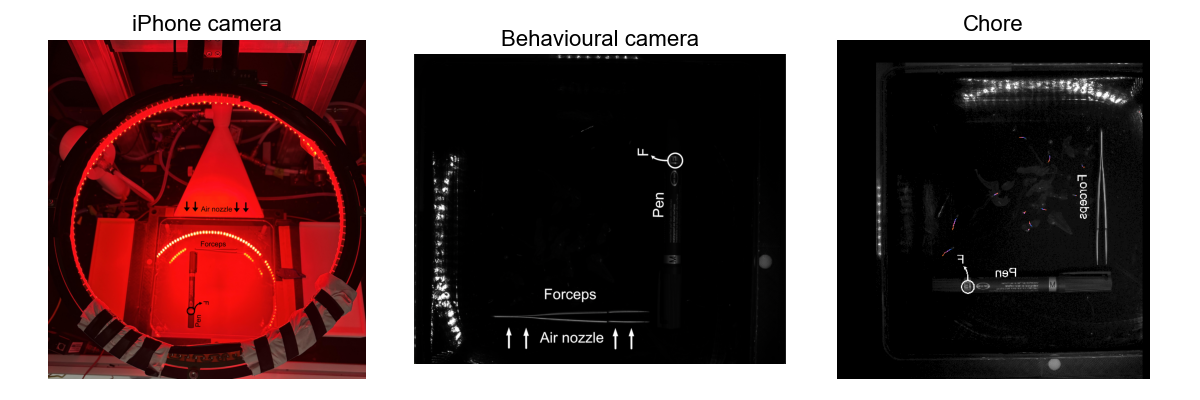

In [13]:
# Display the images
fig = display_setup_images()

## Calculation from Chore program
Now, we see if what we saw from Chore GUI is the same as from the calculations from the output of Chore `.dat` files.

In [14]:
data_folder = "/Users/sharbat/Projects/20250409_162408/"
columns = ["time","x", "y"]
larvae_data = anm_parse.extract_all_larvae(data_folder, columns)

In [15]:
from pprint import pprint
larva_id = 'test01'  # Example larva ID
# Accessing metadata, data, and summary for larva
pprint(larvae_data[larva_id]["metadata"])  # Experiment details
pprint(larvae_data[larva_id]["summary"])   # Summary statistics

{'date': '20240219_140808',
 'effector': 'test',
 'genotype': 'test',
 'raw_protocol': 'none#n#n#n',
 'stimulus_type': 'none#n#n#n',
 'tracker': 't7'}
{'time': {'max': np.float64(30.137),
          'mean': np.float64(14.267793733681463),
          'min': np.float64(0.006),
          'size': 383},
 'x': {'max': np.float64(60.947),
       'mean': np.float64(57.220684073107044),
       'min': np.float64(53.427),
       'size': 383},
 'y': {'max': np.float64(155.391),
       'mean': np.float64(152.02590600522194),
       'min': np.float64(149.433),
       'size': 383}}


In [16]:
def plot_trajectory_over_time(data, larva_id, plot_type="interactive"):
    """
    Plot larva trajectory with either interactive time slider or static colormap.
    
    Parameters:
    -----------
    data : dict
        The larvae data dictionary
    larva_id : str
        ID of the larva to plot
    plot_type : str
        Either "interactive" or "static"
    """
    plt.ioff()
    # Get data
    larva = data[larva_id]['data']
    time = np.array(larva['time'])
    x = np.array(larva['x'])
    y = np.array(larva['y'])
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Set up the RIGHT subplot (reference image) - common to both plot types
    try:
        from PIL import Image
        # Load and display the image
        img = np.array(Image.open('Chore_test20250409_2.png'))
        ax2.imshow(img)
        ax2.set_title('Chore Reference Image')
        ax2.axis('off')  # Hide axes for image
    except Exception as e:
        ax2.text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                 ha='center', va='center', transform=ax2.transAxes)
    
    # Set common axis properties for trajectory plot
    x_padding = (np.max(x) - np.min(x)) * 0.1
    y_padding = (np.max(y) - np.min(y)) * 0.1
    ax1.set_xlim(np.min(x) - x_padding, np.max(x) + x_padding)
    ax1.set_ylim(np.min(y) - y_padding, np.max(y) + y_padding)
    ax1.set_aspect('equal')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.grid(True, alpha=0.3)
    
    if plot_type == "interactive":
        # INTERACTIVE PLOT (with slider)
        point, = ax1.plot([], [], 'o', color='blue', markersize=10)
        
        # Plot full trajectory as background
        ax1.plot(x, y, '-', color='gray', alpha=0.3, linewidth=1)
        ax1.set_title('Larva Trajectory')
        
        def update(frame):
            # Update point position
            point.set_data([x[frame]], [y[frame]])
            ax1.set_title(f'Time: {time[frame]:.2f}s')
            return (point,)
        
        # Create interactive controls
        play = widgets.Play(
            value=0,
            min=0,
            max=len(time) - 1,
            step=1,
            interval=50,
            description="Play"
        )
        
        slider = widgets.IntSlider(
            min=0,
            max=len(time) - 1,
            description='Frame:',
            value=0,
            style={'description_width': 'initial'},
            readout_format='d',
            layout=widgets.Layout(width='800px')
        )
        
        # Link play and slider
        widgets.jslink((play, 'value'), (slider, 'value'))
        
        def update_plot(change):
            if change['type'] == 'change' and change['name'] == 'value':
                update(change['new'])
                fig.canvas.draw_idle()
        
        # Connect events
        slider.observe(update_plot)
        
        # Display controls and figure
        display(widgets.HBox([play, slider]))
        display(fig.canvas)
        
        # Initialize plot
        update_plot({'type': 'change', 'name': 'value', 'new': 0})
        
    elif plot_type == "static":
        # STATIC PLOT (with colormap)
        # Create colormap based on time values
        norm = plt.Normalize(time.min(), time.max())
        cmap = plt.cm.viridis
        
        # Create a scatter plot with points colored by time
        scatter = ax1.scatter(x, y, c=time, cmap=cmap, s=30, alpha=0.8)
        
        # Also plot trajectory line
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = plt.matplotlib.collections.LineCollection(
            segments, cmap=cmap, norm=norm, alpha=0.6
        )
        lc.set_array(time[:-1])
        ax1.add_collection(lc)
        
        # Add colorbar
        cbar = fig.colorbar(scatter, ax=ax1)
        cbar.set_label('Time (s)')
        
        ax1.set_title(f'Larva Trajectory - Static View')
        display(fig.canvas)
    
    plt.tight_layout()
    return fig

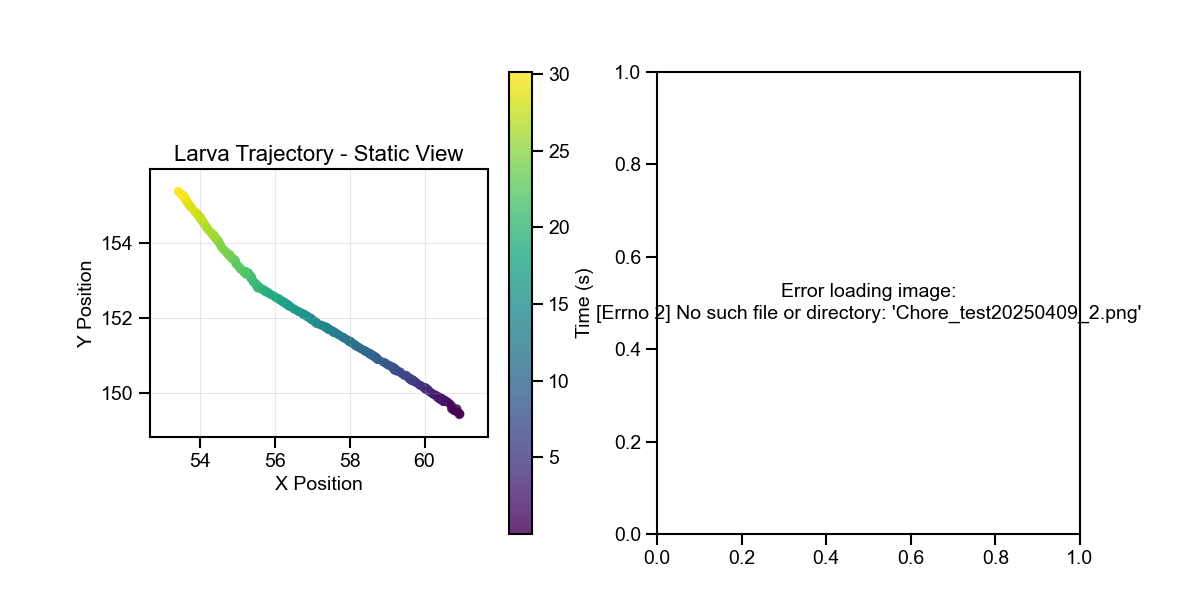

In [17]:
# fig = plot_trajectory_over_time(larvae_data, larva_id, "interactive")  # Default interactive view
fig = plot_trajectory_over_time(larvae_data, larva_id, "static")       # Static colormap view